# MIS780 Advanced AI For Business - Assignment 2 - T2 2021

## Part A:  Deep Learning for Tabular Data

**Student Name:** HOANG MANH NGUYEN

**Student ID:** 219380205

*Markdown formats: All tables and images will be aligned to the left. (Do not remove this code)*

In [ ]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Organise the project structure, get data and run the notebook.
2. Experiment with various MLP architectures and size of its layers.
3. Experiment with dropout layers and their dropout rates.
4. Experiment with layer activation functions (e.g. sigmoid, tanh, elu or relu).
5. Experiment with different optimisers (e.g. SGD, RMSprop, Adam, Adamax, Nadam)
6. Report and tabulate your experimental results.
7. Save the IPYNB notebook, convert it to PDF (via HTML) and submit both for assessment.

**NOTE: In your reponses below, you can create multiple Markdown and Code cells to present your work where needed. Remove the *instructional text in italic* and provide your explanations to the code procedures.**
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

We load all required Python libraries (e.g. pandas, tensorflow, keras)

Also. develop code to define some common features and functions (output display, plots) which will be used in later part

In [ ]:
from __future__ import print_function
import os
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping

Provide code to define any common functions


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Write function to plot all results of model
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

In this section ,we do some data preprocessing: 
- load data from google drive
- check statistical summary and general information
- check missing/blank values
- calculate correlation coefficient for choosing features

Then we prepare data (split and scale) as input data for model 

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data file
EnergyConsumption = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/A2/PartA-SmartHomeEnergyConsumption.csv")
EnergyConsumption.set_index
print('Number of records read: ', EnergyConsumption.size)

Number of records read:  539964


In [ ]:
EnergyConsumption.head(5)

,gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,Total Consuption
0,0.003483,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,0.932833
1,0.003467,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,0.934333
2,0.003467,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,0.931817
3,0.003483,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,1.022050
4,0.003467,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,1.139400


In [ ]:
# Check statistical summary
EnergyConsumption.describe(include="all").transpose()

,count,mean,std,min,25%,50%,75%,max
gen [kW],29998.0,0.056453,0.115127,0.000000,0.003067,0.003350,0.032375,0.554950
Dishwasher [kW],29998.0,0.038770,0.212522,0.000000,0.000017,0.000067,0.000233,1.378650
Furnace 1 [kW],29998.0,0.232167,0.221758,0.002433,0.021617,0.102017,0.479917,1.915517
Furnace 2 [kW],29998.0,0.240812,0.252538,0.002017,0.064600,0.070733,0.567029,0.775417
Home office [kW],29998.0,0.101068,0.115567,0.002467,0.042067,0.049433,0.108700,0.913317
Fridge [kW],29998.0,0.056384,0.072355,0.000133,0.005000,0.005333,0.121400,0.851267
Wine cellar [kW],29998.0,0.018790,0.034726,0.000217,0.006800,0.007100,0.007400,0.229633
Garage door [kW],29998.0,0.013682,0.009739,0.000467,0.012450,0.012817,0.013050,0.341417
Kitchen 12 [kW],29998.0,0.001403,0.019662,0.000017,0.000433,0.000633,0.000733,0.906283
Kitchen 14 [kW],29998.0,0.008986,0.084576,0.000000,0.000050,0.000133,0.000300,1.612117


In [ ]:
# Check information
EnergyConsumption.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gen [kW]          29998 non-null  float64
 1   Dishwasher [kW]   29998 non-null  float64
 2   Furnace 1 [kW]    29998 non-null  float64
 3   Furnace 2 [kW]    29998 non-null  float64
 4   Home office [kW]  29998 non-null  float64
 5   Fridge [kW]       29998 non-null  float64
 6   Wine cellar [kW]  29998 non-null  float64
 7   Garage door [kW]  29998 non-null  float64
 8   Kitchen 12 [kW]   29998 non-null  float64
 9   Kitchen 14 [kW]   29998 non-null  float64
 10  Kitchen 38 [kW]   29998 non-null  float64
 11  Barn [kW]         29998 non-null  float64
 12  Well [kW]         29998 non-null  float64
 13  Microwave [kW]    29998 non-null  float64
 14  Living room [kW]  29998 non-null  float64
 15  Solar [kW]        29998 non-null  float64
 16  temperature       29998 non-null  float6

In [ ]:
# Check any missing values
missing = EnergyConsumption.isnull().values.any()
if missing == False:
  print("There are no missing values")
else:
  print("There are missing values")

There are no missing values


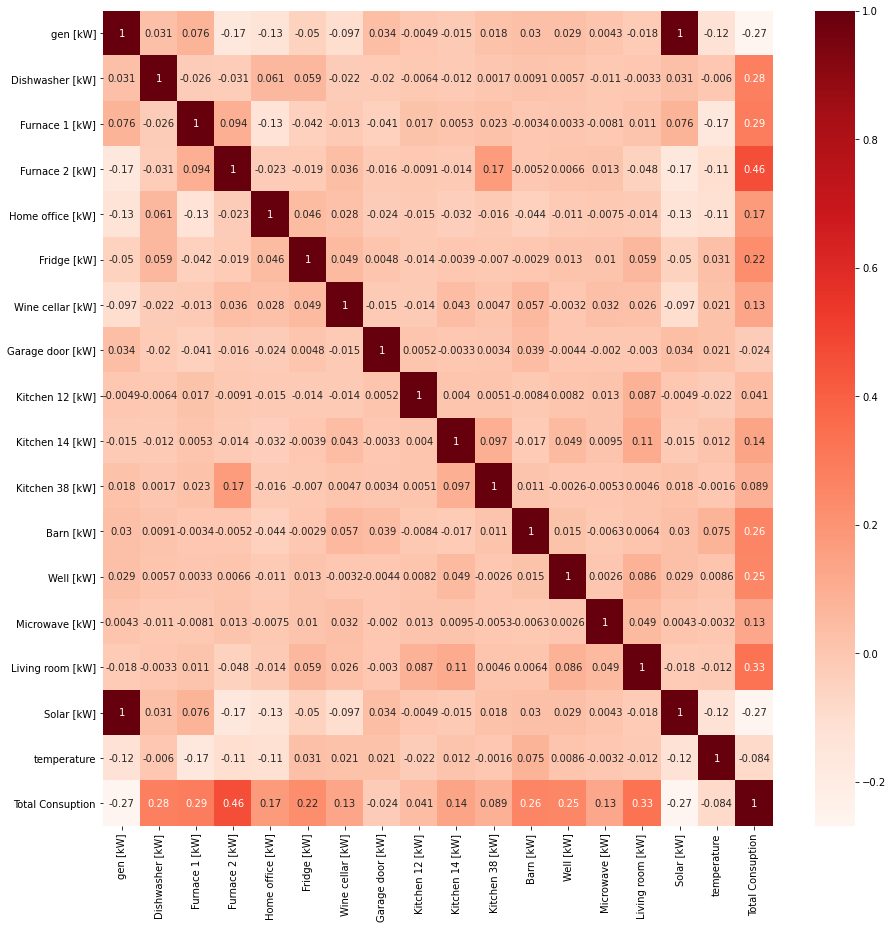

In [ ]:
# Choose features
# Calculate correlation coefficient
correlation = EnergyConsumption.corr()

# Draw heatmap for correlation
plt.figure(figsize=(15,15))
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
print('Base on correlation table and heatmap, the correlation coefficient between all features and label - Total Consumption is very small (highest is 0.46).')
print('Therefore, all features have weak or almost no relationship with the label. \n')

print('We will choose those features which have correlation coefficient >= 0.2 or <= -0.2.')
print ('Next, we remove all features which has high multi collinearity.')
print ('There are 2 features having correlation = 1: gen KW and Solar KW -> remove "gen KW", keep "Solar KW". \n')

print('The feartures and label are: Dishwasher, Furnace 1, Furnace 2, Fridge, Barn, Well, Living room, Total Consuption. \n')

EnergyConsumption = EnergyConsumption[['Dishwasher [kW]','Furnace 1 [kW]','Furnace 2 [kW]','Fridge [kW]',
                                       'Barn [kW]','Well [kW]','Living room [kW]','Solar [kW]','Total Consuption']]
EnergyConsumption.head()

Base on correlation table and heatmap, the correlation coefficient between all features and label - Total Consumption is very small (highest is 0.46).
Therefore, all features have weak or almost no relationship with the label. 

We will choose those features which have correlation coefficient >= 0.2 or <= -0.2.
Next, we remove all features which has high multi collinearity.
There are 2 features having correlation = 1: gen KW and Solar KW -> remove "gen KW", keep "Solar KW". 

The feartures and label are: Dishwasher, Furnace 1, Furnace 2, Fridge, Barn, Well, Living room, Total Consuption. 



,Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Fridge [kW],Barn [kW],Well [kW],Living room [kW],Solar [kW],Total Consuption
0,0.000033,0.020700,0.061917,0.124150,0.031350,0.001017,0.001517,0.003483,0.932833
1,0.000000,0.020717,0.063817,0.124000,0.031500,0.001017,0.001650,0.003467,0.934333
2,0.000017,0.020700,0.062317,0.123533,0.031517,0.001000,0.001650,0.003467,0.931817
3,0.000017,0.106900,0.068517,0.123133,0.031500,0.001017,0.001617,0.003483,1.022050
4,0.000133,0.236933,0.063983,0.122850,0.031500,0.001017,0.001583,0.003467,1.139400


Next step:

- Split data for training and validation (0.7/0.3).
- Scale all training and validation in range (0,1)

-> Input data is ready for training model

In [ ]:
# Split data for training and validation
label = 'Total Consuption'
train_size, valid_size, test_size = (0.7, 0.3, 0.0)
energy_train, energy_valid = train_test_split(EnergyConsumption, 
                                      test_size=valid_size, 
                                      random_state=2021)

In [ ]:
energy_y_train = energy_train[[label]]
energy_x_train = energy_train.drop(label, axis=1)

energy_y_valid = energy_valid[[label]]
energy_x_valid = energy_valid.drop(label, axis=1)

print('Size of training set: ', len(energy_x_train))
print('Size of validation set: ', len(energy_x_valid))

Size of training set:  20998
Size of validation set:  9000


In [ ]:
# create a scaling model using training set and use it to scale both training and validation data

# scaler = StandardScaler()

scaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(energy_x_train)

energy_x_train = pd.DataFrame(scaler.transform(energy_x_train), 
                            columns = energy_x_train.columns, index = energy_x_train.index)
energy_x_valid = pd.DataFrame(scaler.transform(energy_x_valid), 
                            columns = energy_x_valid.columns, index = energy_x_valid.index)

print('X train min =', round(energy_x_train.min().min(),4), '; max =', round(energy_x_train.max().max(), 4))
print('X valid min =', round(energy_x_valid.min().min(),4), '; max =', round(energy_x_valid.max().max(), 4))

X train min = 0.0 ; max = 1.0
X valid min = 0.0 ; max = 1.0122


In [ ]:
# Convert pandas data frames to np arrays

arr_x_train = np.array(energy_x_train)
arr_y_train = np.array(energy_y_train)
arr_x_valid = np.array(energy_x_valid)
arr_y_valid = np.array(energy_y_valid)

print('Training shape:', arr_x_train.shape)
print('Training samples: ', arr_x_train.shape[0])
print('Validation samples: ', arr_x_valid.shape[0])


Training shape: (20998, 8)
Training samples:  20998
Validation samples:  9000


<a id = "cell_model"></a>
## 3. Model Construction

In this section, we create 5 different Sequential models with various settings:
- Experiment with various MLP architectures and size of its layers.
- Experiment with dropout layers and their dropout rates.
- Experiment with layer activation functions (e.g. sigmoid, tanh, elu or relu).
- Experiment with different optimisers (e.g. SGD, RMSprop, Adam, Nadam)

For all models, loss function = mean_squared_error, epochs = 500.

**Model 1**: Dense and Drop out layer

- "tanh" function

- no regularizers

- use Nadam optimizer





In [ ]:
#Model 1
def model_1(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal',))
        #kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="tanh", kernel_initializer='normal',))
        #kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="tanh", kernel_initializer='normal',))
        #kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))              
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        #optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False),
        #optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        #optimizer=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False),
        optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[metrics.mae])
    return(t_model)

**Model 2** 

- same setting as Model 1

- but add regularizers (l1,l2)

In [ ]:
#Model 2
def model_2(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="tanh", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="tanh", kernel_initializer='normal',
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))              
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        #optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False),
        #optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        #optimizer=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False),
        optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[metrics.mae])
    return(t_model)

**Model 3**

- keep same settings as model 2, but test for other activation functions

 -> best is "relu" 

Therefore, we keep "relu" function for this model



In [ ]:
#Model 3
def model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', input_shape=(x_size,))) #tanh, sigmoid, elu, relu
    t_model.add(Dropout(0.2))
    t_model.add(Dense(80, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal',
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))              
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        #optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False),
        #optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        #optimizer=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False),
        optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[metrics.mae])
    return(t_model)

**Model 4**
- keep same settings as model 3
  
- test various optimizers (Adam, Nadam, SGD, RMSpop)
 
 -> best is Adam optimizer

Therefore, we keep Adam optimizer for this model

In [ ]:
#Model 4
def model_4(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(80, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal',
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))              
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False),
        #optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        #optimizer=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False),
        #optimizer=Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[metrics.mae])
    return(t_model)

**Model 5**
- keep same settings as model 4

- test with Adam optimizer with learning rate = 0.0001

In [ ]:
#Model 5
def model_5(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(100, activation="relu", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(80, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(50, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal',
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))              
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False),
        #optimizer=SGD(learning_rate=0.01, momentum=0.0, nesterov=False),
        #optimizer=RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=False),
        #optimizer=Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        metrics=[metrics.mae])
    return(t_model)

<a id = "cell_execution"></a>
## 4. Model Execution

In this section:
- fit the models
- record and plot the history of training and validation
- report the performance of the trained model on the both the training and the test sets

**Model 1**

In [ ]:
run_model_1 = model_1(arr_x_train.shape[1], arr_y_train.shape[1])
run_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               900       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1

In [ ]:
# Fit model with callbacks method
keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]

test1 = run_model_1.fit(arr_x_train, arr_y_train,
    batch_size=128,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
165/165 - 5s - loss: 0.2853 - mean_absolute_error: 0.3196 - val_loss: 0.6608 - val_mean_absolute_error: 0.7421
Epoch 2/500
165/165 - 1s - loss: 0.1724 - mean_absolute_error: 0.2406 - val_loss: 0.1496 - val_mean_absolute_error: 0.2159
Epoch 3/500
165/165 - 1s - loss: 0.1620 - mean_absolute_error: 0.2321 - val_loss: 0.1464 - val_mean_absolute_error: 0.2152
Epoch 4/500
165/165 - 1s - loss: 0.1617 - mean_absolute_error: 0.2312 - val_loss: 0.2751 - val_mean_absolute_error: 0.4312
Epoch 5/500
165/165 - 1s - loss: 0.1594 - mean_absolute_error: 0.2296 - val_loss: 0.1616 - val_mean_absolute_error: 0.2006
Epoch 6/500
165/165 - 1s - loss: 0.1582 - mean_absolute_error: 0.2274 - val_loss: 0.1461 - val_mean_absolute_error: 0.2076
Epoch 7/500
165/165 - 1s - loss: 0.1575 - mean_absolute_error: 0.2262 - val_loss: 0.1455 - val_mean_absolute_error: 0.2156
Epoch 8/500
165/165 - 1s - loss: 0.1573 - mean_absolute_error: 0.2259 - val_loss: 0.1467 - val_mean_absolute_error: 0.2188
Epoch 9/500
165/

In [ ]:
# Evaluate model
train_score1 = run_model_1.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score1 = run_model_1.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(energy_y_train['Total Consuption'].mean(), 4))
print('Train MAE: ', round(train_score1[1], 4), ', Train Loss: ', round(train_score1[0], 4)) 
print('Val Mean:', round(energy_y_valid['Total Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score1[1], 4), ', Val Loss: ', round(valid_score1[0], 4))

Train Mean: 1.0851
Train MAE:  0.2123 , Train Loss:  0.1589
Val Mean: 1.0673
Val MAE:  0.2093 , Val Loss:  0.153


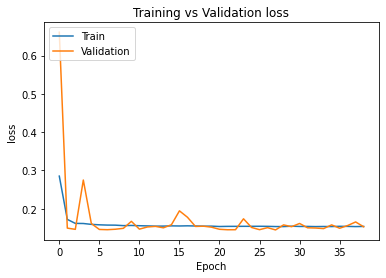

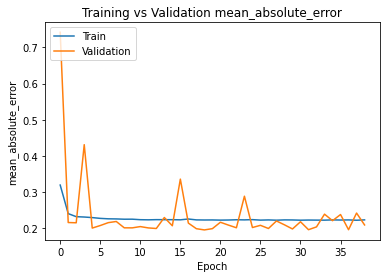

In [ ]:
hist1 = pd.DataFrame(test1.history)
plot_hist(hist1, xsize=6, ysize=4)

**Model 2**

In [ ]:
run_model_2 = model_2(arr_x_train.shape[1], arr_y_train.shape[1])
run_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               900       
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)               

In [ ]:
# Fit model with callbacks method
keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]

test2 = run_model_2.fit(arr_x_train, arr_y_train,
    batch_size= 128,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
165/165 - 3s - loss: 1.9747 - mean_absolute_error: 0.4641 - val_loss: 0.5336 - val_mean_absolute_error: 0.2876
Epoch 2/500
165/165 - 1s - loss: 0.5071 - mean_absolute_error: 0.2983 - val_loss: 0.4501 - val_mean_absolute_error: 0.2854
Epoch 3/500
165/165 - 1s - loss: 0.4423 - mean_absolute_error: 0.2808 - val_loss: 0.3967 - val_mean_absolute_error: 0.2385
Epoch 4/500
165/165 - 1s - loss: 0.4040 - mean_absolute_error: 0.2742 - val_loss: 0.3645 - val_mean_absolute_error: 0.2476
Epoch 5/500
165/165 - 1s - loss: 0.3848 - mean_absolute_error: 0.2687 - val_loss: 0.3553 - val_mean_absolute_error: 0.2546
Epoch 6/500
165/165 - 1s - loss: 0.3723 - mean_absolute_error: 0.2676 - val_loss: 0.3414 - val_mean_absolute_error: 0.2436
Epoch 7/500
165/165 - 1s - loss: 0.3639 - mean_absolute_error: 0.2691 - val_loss: 0.3301 - val_mean_absolute_error: 0.2406
Epoch 8/500
165/165 - 1s - loss: 0.3514 - mean_absolute_error: 0.2678 - val_loss: 0.3268 - val_mean_absolute_error: 0.2455
Epoch 9/500
165/

In [ ]:
# Evaluate model
train_score2 = run_model_2.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score2 = run_model_2.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(energy_y_train['Total Consuption'].mean(), 4))
print('Train MAE: ', round(train_score2[1], 4), ', Train Loss: ', round(train_score2[0], 4)) 
print('Val Mean:', round(energy_y_valid['Total Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score2[1], 4), ', Val Loss: ', round(valid_score2[0], 4))

Train Mean: 1.0851
Train MAE:  0.2341 , Train Loss:  0.2281
Val Mean: 1.0673
Val MAE:  0.2319 , Val Loss:  0.2218


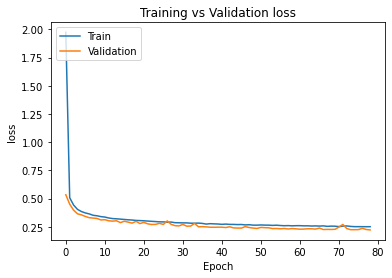

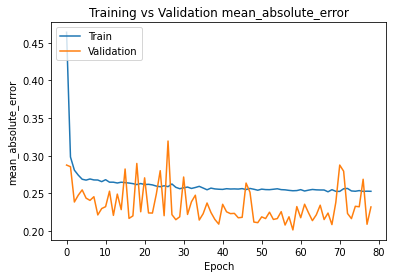

In [ ]:
hist2 = pd.DataFrame(test2.history)
plot_hist(hist2, xsize=6, ysize=4)

**Model 3**

In [ ]:
run_model_3 = model_3(arr_x_train.shape[1], arr_y_train.shape[1])
run_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               900       
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_9 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)               

In [ ]:
# Fit model with callbacks method
keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]
test3 = run_model_3.fit(arr_x_train, arr_y_train,
    batch_size=128,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
165/165 - 3s - loss: 2.0853 - mean_absolute_error: 0.5929 - val_loss: 0.5611 - val_mean_absolute_error: 0.3620
Epoch 2/500
165/165 - 1s - loss: 0.5127 - mean_absolute_error: 0.3293 - val_loss: 0.4313 - val_mean_absolute_error: 0.2732
Epoch 3/500
165/165 - 1s - loss: 0.4482 - mean_absolute_error: 0.3129 - val_loss: 0.3861 - val_mean_absolute_error: 0.2544
Epoch 4/500
165/165 - 1s - loss: 0.4206 - mean_absolute_error: 0.3060 - val_loss: 0.3920 - val_mean_absolute_error: 0.2653
Epoch 5/500
165/165 - 1s - loss: 0.4060 - mean_absolute_error: 0.3001 - val_loss: 0.3619 - val_mean_absolute_error: 0.2902
Epoch 6/500
165/165 - 1s - loss: 0.3914 - mean_absolute_error: 0.2990 - val_loss: 0.3435 - val_mean_absolute_error: 0.2484
Epoch 7/500
165/165 - 1s - loss: 0.3802 - mean_absolute_error: 0.2972 - val_loss: 0.3380 - val_mean_absolute_error: 0.2525
Epoch 8/500
165/165 - 1s - loss: 0.3723 - mean_absolute_error: 0.2960 - val_loss: 0.3354 - val_mean_absolute_error: 0.2527
Epoch 9/500
165/

In [ ]:
# Evaluate model
train_score3 = run_model_3.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score3 = run_model_3.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(energy_y_train['Total Consuption'].mean(), 4))
print('Train MAE: ', round(train_score3[1], 4), ', Train Loss: ', round(train_score3[0], 4)) 
print('Val Mean:', round(energy_y_valid['Total Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score3[1], 4), ', Val Loss: ', round(valid_score3[0], 4))

Train Mean: 1.0851
Train MAE:  0.3123 , Train Loss:  0.254
Val Mean: 1.0673
Val MAE:  0.311 , Val Loss:  0.2512


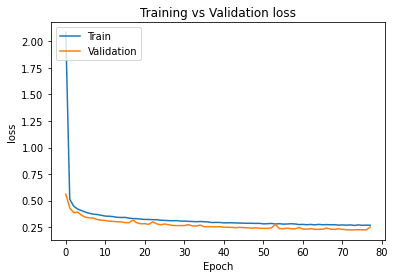

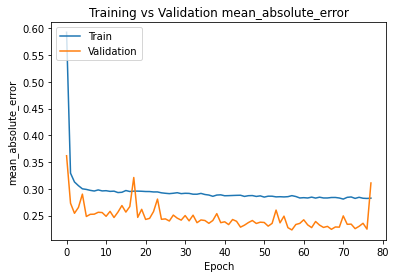

In [ ]:
hist3 = pd.DataFrame(test3.history)
plot_hist(hist3, xsize=6, ysize=4)

**Model 4**

In [ ]:
run_model_4 = model_4(arr_x_train.shape[1], arr_y_train.shape[1])
run_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               900       
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)               

In [ ]:
# Fit model with callbacks method
keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]
test4 = run_model_4.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
329/329 - 3s - loss: 1.2655 - mean_absolute_error: 0.4901 - val_loss: 0.3944 - val_mean_absolute_error: 0.2769
Epoch 2/500
329/329 - 1s - loss: 0.4127 - mean_absolute_error: 0.3118 - val_loss: 0.3479 - val_mean_absolute_error: 0.2556
Epoch 3/500
329/329 - 1s - loss: 0.3784 - mean_absolute_error: 0.3016 - val_loss: 0.3259 - val_mean_absolute_error: 0.2504
Epoch 4/500
329/329 - 1s - loss: 0.3624 - mean_absolute_error: 0.2971 - val_loss: 0.3158 - val_mean_absolute_error: 0.2538
Epoch 5/500
329/329 - 1s - loss: 0.3560 - mean_absolute_error: 0.2976 - val_loss: 0.3092 - val_mean_absolute_error: 0.2540
Epoch 6/500
329/329 - 1s - loss: 0.3438 - mean_absolute_error: 0.2967 - val_loss: 0.2981 - val_mean_absolute_error: 0.2554
Epoch 7/500
329/329 - 1s - loss: 0.3389 - mean_absolute_error: 0.2983 - val_loss: 0.2911 - val_mean_absolute_error: 0.2596
Epoch 8/500
329/329 - 1s - loss: 0.3306 - mean_absolute_error: 0.2971 - val_loss: 0.2849 - val_mean_absolute_error: 0.2602
Epoch 9/500
329/

In [ ]:
# Evaluate model
train_score4 = run_model_4.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score4 = run_model_4.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(energy_y_train['Total Consuption'].mean(), 4))
print('Train MAE: ', round(train_score4[1], 4), ', Train Loss: ', round(train_score4[0], 4)) 
print('Val Mean:', round(energy_y_valid['Total Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score4[1], 4), ', Val Loss: ', round(valid_score4[0], 4))

Train Mean: 1.0851
Train MAE:  0.254 , Train Loss:  0.2201
Val Mean: 1.0673
Val MAE:  0.2531 , Val Loss:  0.2163


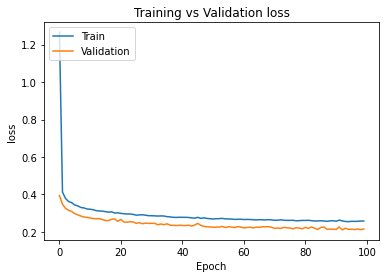

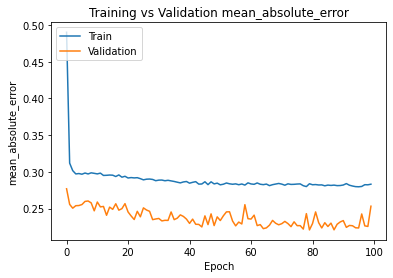

In [ ]:
hist4 = pd.DataFrame(test4.history)
plot_hist(hist4, xsize=6, ysize=4)

**Model 5**

In [ ]:
run_model_5 = model_5(arr_x_train.shape[1], arr_y_train.shape[1])
run_model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               900       
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 80)                8080      
_________________________________________________________________
dropout_17 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                4050      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)               

In [ ]:
# Fit model with callbacks method
keras_callbacks = [EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)]
test5 = run_model_5.fit(arr_x_train, arr_y_train,
    batch_size=64,
    epochs=500,
    shuffle=True,
    verbose=2,
    validation_data=(arr_x_valid, arr_y_valid),
    callbacks=keras_callbacks)

Epoch 1/500
329/329 - 3s - loss: 5.0320 - mean_absolute_error: 0.9340 - val_loss: 3.1106 - val_mean_absolute_error: 0.6524
Epoch 2/500
329/329 - 1s - loss: 2.0411 - mean_absolute_error: 0.4628 - val_loss: 1.3392 - val_mean_absolute_error: 0.4039
Epoch 3/500
329/329 - 1s - loss: 1.0381 - mean_absolute_error: 0.4059 - val_loss: 0.7825 - val_mean_absolute_error: 0.3764
Epoch 4/500
329/329 - 1s - loss: 0.7036 - mean_absolute_error: 0.3812 - val_loss: 0.6023 - val_mean_absolute_error: 0.3483
Epoch 5/500
329/329 - 1s - loss: 0.5984 - mean_absolute_error: 0.3618 - val_loss: 0.5300 - val_mean_absolute_error: 0.3225
Epoch 6/500
329/329 - 1s - loss: 0.5468 - mean_absolute_error: 0.3452 - val_loss: 0.4881 - val_mean_absolute_error: 0.3015
Epoch 7/500
329/329 - 1s - loss: 0.5171 - mean_absolute_error: 0.3356 - val_loss: 0.4610 - val_mean_absolute_error: 0.2895
Epoch 8/500
329/329 - 1s - loss: 0.4949 - mean_absolute_error: 0.3275 - val_loss: 0.4410 - val_mean_absolute_error: 0.2821
Epoch 9/500
329/

In [ ]:
# Evaluate model
train_score5 = run_model_5.evaluate(arr_x_train, arr_y_train, verbose=0)
valid_score5 = run_model_5.evaluate(arr_x_valid, arr_y_valid, verbose=0)

print('Train Mean:', round(energy_y_train['Total Consuption'].mean(), 4))
print('Train MAE: ', round(train_score5[1], 4), ', Train Loss: ', round(train_score5[0], 4)) 
print('Val Mean:', round(energy_y_valid['Total Consuption'].mean(), 4))
print('Val MAE: ', round(valid_score5[1], 4), ', Val Loss: ', round(valid_score5[0], 4))

Train Mean: 1.0851
Train MAE:  0.2418 , Train Loss:  0.2441
Val Mean: 1.0673
Val MAE:  0.2391 , Val Loss:  0.2371


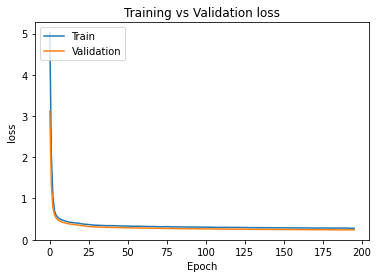

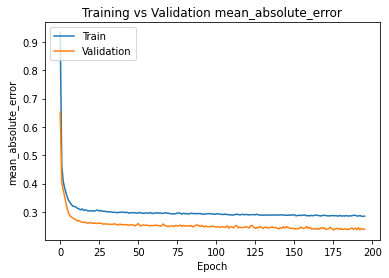

In [ ]:
hist5 = pd.DataFrame(test5.history)
plot_hist(hist5, xsize=6, ysize=4)

<a id = "cell_report"></a>
## 5. Experiments Report

### **Summary** 

To compare performance between models, we improve step by step from the 1st model. 

From model 1, we start with a activation and default optimizer, drop out layer and no regularization 

And after each model, we will add and change more settings to improve the performance of the model 

Below is the discussion of all models results and recommendation of choosing the best model.

**Summary of experimental results**


| Model# |  Train MAE | Valid MAE |
| :-: | -: | -: |
| 1 | 0.2123 | 0.2093 |  |
| 2 | 0.2341 | 0.2319  |   |
| 3 | 0.3123 | 0.311  |   |
| 4 | 0.254 | 0.2531  |   |
| 5 | 0.2418 | 0.2391  |   |

<br>

**Model 1**: Results are smallest among 5 models. However, both graphs are not good fit. there is some fluctuation in both loss function and MAE. They indicate that validation set can be small compared to training test for which the model can test properly

But it runs very quick



**Model 2**: We keep same settings as model 1, but add regularizers (l1,l2), As the result, model's performance increases.

- graph of loss function: good fit 

- but have same issue as model 1 on MAE graph when the model can not test properly on validation data

**Model 3**: 

To improve further model performance, we test different activation functions
on model 3 (same settings as model 2, only change activation functions)

-> The activation functions give the best result is "relu"

- loss function graph is a good fit between training and validation

- MAE graph is still undertrain, but it fluctuates with lower attitude than that of model 2

-> Therefore, model's performance is actually better eventhough the results of loss and MAE are higher


**Model 4**: in this model, we decide to test different optimizers. We keep the same structure as model 3, only change to different optimizers.

Therefore, the best optimizer is Adam

Look at graph:
- loss function graph is good fit
- MAE graph is even less fluctuated with lower attitude compared to previous models.

The results of loss function and MAE are also lower

**Model 5**: According to 4 previous models, loss function is a good fit, however, MAE is still a big gap with fluctuation between training and validation

Therefore, in  this model, we change lower learning rate for optimizer Adam (0.001 to 0.0001)

- loss function graph: very good fit. 

- MAE graph : quite fit as the gap between training line and validition line  is closer. Validation line also flattens and smoothen compared to training line

Both Train-MAE and Valid-MAE are smallest among 5 models


-> Model performance improves


**Overall, there are some conclusions:**

- Models with Adam optimizer perform better than others. 

- Sigmoid and tanh should be avoided due to vanishing gradient problem.

- For all testing activations: ReLU >  ELU > tanh > sigmoid.
 

**Recommendation**

Based on all above analysis

**Model 5**: "relu" activation, Adam optimizer (slower learning rate = 0.0001) is the best model, giving the lowest results of loss function and MAE. And their graphs are also the best among other models.